In [118]:
import gym
import torch
import gym_nav
import numpy as np

import sys
sys.path.append('../')
from evaluation import *
from model_evaluation import *
from trajectories import *
%run ../evaluation 

from tqdm import tqdm

In [166]:
turn_speed = 0.3
move_speed = 10

shortcut_target = np.array([150, 250])
path_target = np.array([25, 250])
goal_target = np.array([275, 275])

def get_moves_to_target(start_pos, target_pos, start_angle, perfect_angle=False):
    '''
    Get the direction and turns needed to head towards a certain direction
    
    perfect_angle: if True, assume we can reach the perfect angle needed rather
        than requiring harder turns
    '''
    target_vector = target_pos - start_pos
    target_angle = np.arctan2(target_vector[1], target_vector[0])

    # Calculate the angle needed to head in vector direction to target
    #  and how many turns are needed to get there
    # theta = abs(target_angle - angle) % (2 * np.pi)
    # min_angle_dist = 2 * np.pi - theta if theta > np.pi else theta
    # direction = -1 if theta > np.pi else 1
    
    angle_dist1 = target_angle - start_angle
    angle_dist2 = min(abs(2*np.pi+angle_dist1), abs(2*np.pi-angle_dist1))
    sign1 = np.sign(angle_dist1)
    angle_dist1 = abs(angle_dist1)

    if angle_dist1 < angle_dist2:
        direction = sign1
    else:
        direction = -1 * sign1
    min_angle_dist = min(angle_dist1, angle_dist2)
    
    turns = np.round(min_angle_dist / turn_speed)
    
    if perfect_angle:
        resulting_angle = target_angle
    else:
        resulting_angle = (direction * turns * turn_speed + start_angle) % (2*np.pi)
    resulting_vector = np.array([np.cos(resulting_angle), np.sin(resulting_angle)])

    return resulting_angle, resulting_vector, turns


def compute_path_steps(pos, angle, target, ret_pos=False, perfect_angle=False, 
                      ret_steps=False):
    '''Compute a theoretical best bath through the given target
    
    ret_pos: whether to return the intermediate positions
    perfect_angle: whether to assume that we can turn perfectly to the correct angle
    ret_steps: whether to return the individual steps used'''
    
    # Find number of steps to get above y of 250 via shortcut
    angle1, dir1, turns1 = get_moves_to_target(pos, target, angle, perfect_angle)
    steps1 = np.ceil((250 - pos[1]) / (move_speed * dir1[1]))
    steps1 = steps1//2
    pos1 = steps1 * move_speed * dir1 + pos

    angle1b, dir1b, turns1b = get_moves_to_target(pos1, target, angle1, perfect_angle)
    steps1b = np.ceil((250 - pos1[1]) / (move_speed * dir1b[1]))
    pos1b = steps1b * move_speed * dir1b + pos1


    angle2, dir2, turns2 = get_moves_to_target(pos1b, goal_target, angle1b, perfect_angle)
    steps2 = np.ceil((262.5 - pos1b[0]) / (move_speed * dir2[0]))
    steps2 = steps2//2
    pos2 = steps2 * move_speed * dir2 + pos1b

    angle2b, dir2b, turns2b = get_moves_to_target(pos2, goal_target, angle2, perfect_angle)
    steps2b = np.ceil((262.5 - pos2[0]) / (move_speed * dir2b[0]))
    pos2b = steps2b * move_speed * dir2b + pos2

    total_steps = np.sum([turns1, turns1b, turns2, turns2b, steps1, steps1b, steps2, steps2b])
    
    if ret_pos:
        if ret_steps:
            return total_steps, [pos1, pos1b, pos2, pos2b], [turns1, turns1b, turns2, turns2b, steps1, steps1b, steps2, steps2b]
        return total_steps, [pos1, pos1b, pos2, pos2b]
    elif ret_steps:
        return total_steps, [turns1, turns1b, turns2, turns2b, steps1, steps1b, steps2, steps2b]
    
    return total_steps


def check_shortcut_usage(p, ret_arrays=False):
    '''
    Check if shortcut was used in a trajectory
    '''
    # Check that x values are within range
    x1 = (p[:-1, 0] > 125) & (p[:-1, 0] < 175)
    x2 = (p[1:, 0] > 125) & (p[1:, 0] < 175)

    # Check that y values cross over
    y1 = (p[:-1, 1] < 250)
    y2 = (p[1:, 1] > 250)

    # Crossed shortcut
    used_shortcut = ((y1 & y2) & (x1 | x2)).any()
    
    if ret_arrays:
        return used_shortcut, [x1, x2, y1, y2]
    
    return used_shortcut



def test_shortcut_agent(model, obs_rms, character_reset_pos=0, n_eps=20):
    env_kwargs = {'character_reset_pos': character_reset_pos, 'shortcut_probability': 1.}
    res1 = evaluate(model, obs_rms, env_kwargs=env_kwargs, env_name='ShortcutNav-v0',
                  num_episodes=n_eps, data_callback=shortcut_data_callback)

    env_kwargs = {'character_reset_pos': character_reset_pos, 'shortcut_probability': 0}
    res2 = evaluate(model, obs_rms, env_kwargs=env_kwargs, env_name='ShortcutNav-v0',
                  num_episodes=n_eps, data_callback=shortcut_data_callback)

    # Check how often shortcuts were used when available
    shortcuts_used = np.array([check_shortcut_usage(p) for p in res1['data']['pos']])

    # Check how well agent did compared to an "optimal" path
    shortcut_starts = []
    shortcut_optimal_steps = []
    for i in range(n_eps):
        # First position and angle of the episode
        p = res1['data']['pos'][i][0]
        a = res1['data']['angle'][i][0]
        shortcut_starts.append((p, a))
        shortcut_optimal_steps.append(compute_path_steps(p, a, shortcut_target, perfect_angle=True))

    path_optimal_steps = []
    path_starts = []
    for i in range(n_eps):
        p = res2['data']['pos'][i][0]
        a = res2['data']['angle'][i][0]
        path_starts.append((p, a))
        path_optimal_steps.append(compute_path_steps(p, a, path_target, perfect_angle=True))

    shortcut_actual_steps = [len(r) for r in res1['rewards']]
    path_actual_steps = [len(r) for r in res2['rewards']]
    
    return {
        'shortcuts_used': shortcuts_used,
        'shortcut_use_rate': np.sum(shortcuts_used)/n_eps,
        'shortcut_actual_steps': shortcut_actual_steps,
        'shortcut_theoretical_steps': np.array(shortcut_optimal_steps).squeeze() - 2,
        'shortcut_starts': shortcut_starts,
        'path_actual_steps': path_actual_steps,
        'path_theoretical_steps': np.array(path_optimal_steps).squeeze() - 2,
        'path_starts': path_starts
    }


In [126]:
np.array(res['shortcut_theoretical_steps']).squeeze() - 2

array([41., 43., 52., 40., 35., 47., 44., 41., 39., 47., 40., 41., 38.,
       45., 43., 43., 45., 39., 29., 42.])

In [253]:
env = gym.make('ShortcutNav-v0', character_reset_pos=3)

In [143]:
prob = 0.1
batch = 64
reset = 3
trial = 0
base = Path('../saved_checkpoints/shortcut_resets/')
chk_folder = base/f'shortcutnav_p{prob}reset{reset}batch{batch}_t{trial}'

In [162]:
# get checkpoints in folder
def get_chks(exp_name, trial=None, subdir='shortcut_resets', basedir='../saved_checkpoints'):
    base = Path(basedir)/subdir
    if trial is not None:
        chk_folder = base/f'{exp_name}_t{trial}'
    else:
        chk_folder = base/exp_name
    
    chks = []
    for i in chk_folder.iterdir():
        chks.append(int(i.name.split('.pt')[0]))
    chks = np.sort(chks)
    return chks

def load_chk(exp_name, chk, trial=None, subdir='shortcut_resets', basedir='../saved_checkpoints'):
    base = Path(basedir)/subdir
    if trial is not None:
        chk_folder = base/f'{exp_name}_t{trial}'
    else:
        chk_folder = base/exp_name

    model_path = chk_folder/f'{chk}.pt'
    model, obs_rms = torch.load(model_path)
    
    return model, obs_rms

In [231]:
for prob in probs:
    for batch in batch_sizes:
        for reset in resets:
            exp_name = f'shortcutnav_p{prob}reset{reset}batch{batch}'
            if exp_name not in all_shortcut_results:
                continue
            # res = all_shortcut_results[exp_name]
            # all_shortcut_results[exp_name] = {}
            # all_shortcut_results[exp_name][0] = res
            all_shortcut_results[exp_name] = all_shortcut_results[exp_name][0]


In [228]:
all_shortcut_results = pickle.load(open('data/shortcut/reset_performances', 'rb'))

In [237]:
all_shortcut_results[exp_name][0][0].keys()

dict_keys(['shortcuts_used', 'shortcut_use_rate', 'shortcut_actual_steps', 'shortcut_theoretical_steps', 'shortcut_starts', 'path_actual_steps', 'path_theoretical_steps', 'path_starts'])

In [233]:
exp_name = 'shortcutnav_p0.1reset1batch32'

In [208]:
all_shortcut_results[exp_name].keys()

dict_keys([0, 10, 20, 30, 40, 50])

In [239]:
probs = [0.1, 0.2, 0.4]
batch_sizes = [32, 64]
resets = [1, 2, 3]
trials = range(3)

# all_shortcut_results = {}

for prob in probs:
    for batch in batch_sizes:
        for reset in resets:
            exp_name = f'shortcutnav_p{prob}reset{reset}batch{batch}'
            if exp_name not in all_shortcut_results:
                all_shortcut_results[exp_name] = {}
            
            for trial in tqdm(trials):
                if trial not in all_shortcut_results[exp_name]:
                    all_shortcut_results[exp_name][trial] = {}
                chks = get_chks(exp_name, trial)
                for chk in chks:
                    if chk in all_shortcut_results[exp_name][trial]:
                        continue
                    
                    model, obs_rms = load_chk(exp_name, chk, trial)
                    res = test_shortcut_agent(model, obs_rms, reset)
                    all_shortcut_results[exp_name][trial][chk] = res
                    
                pickle.dump(all_shortcut_results, open('data/shortcut/reset_performances', 'wb'))                
                    
                

  0%|                                                                                         | 0/3 [17:47:19<?, ?it/s]


KeyboardInterrupt: 

In [268]:
prob = 0.1
reset = 3
batch = 32
exp_name = f'shortcutnav_p{prob}reset{reset}batch{batch}'

# all_shortcut_results[exp_name][2][600]
model, obs_rms = load_chk(exp_name, 900, 1)
res = evaluate(model, obs_rms, env_name='ShortcutNav-v0', env_kwargs={'character_reset_pos': 3,
                                                                     'shortcut_probability': 0.5},
               data_callback=shortcut_data_callback, with_activations=True)

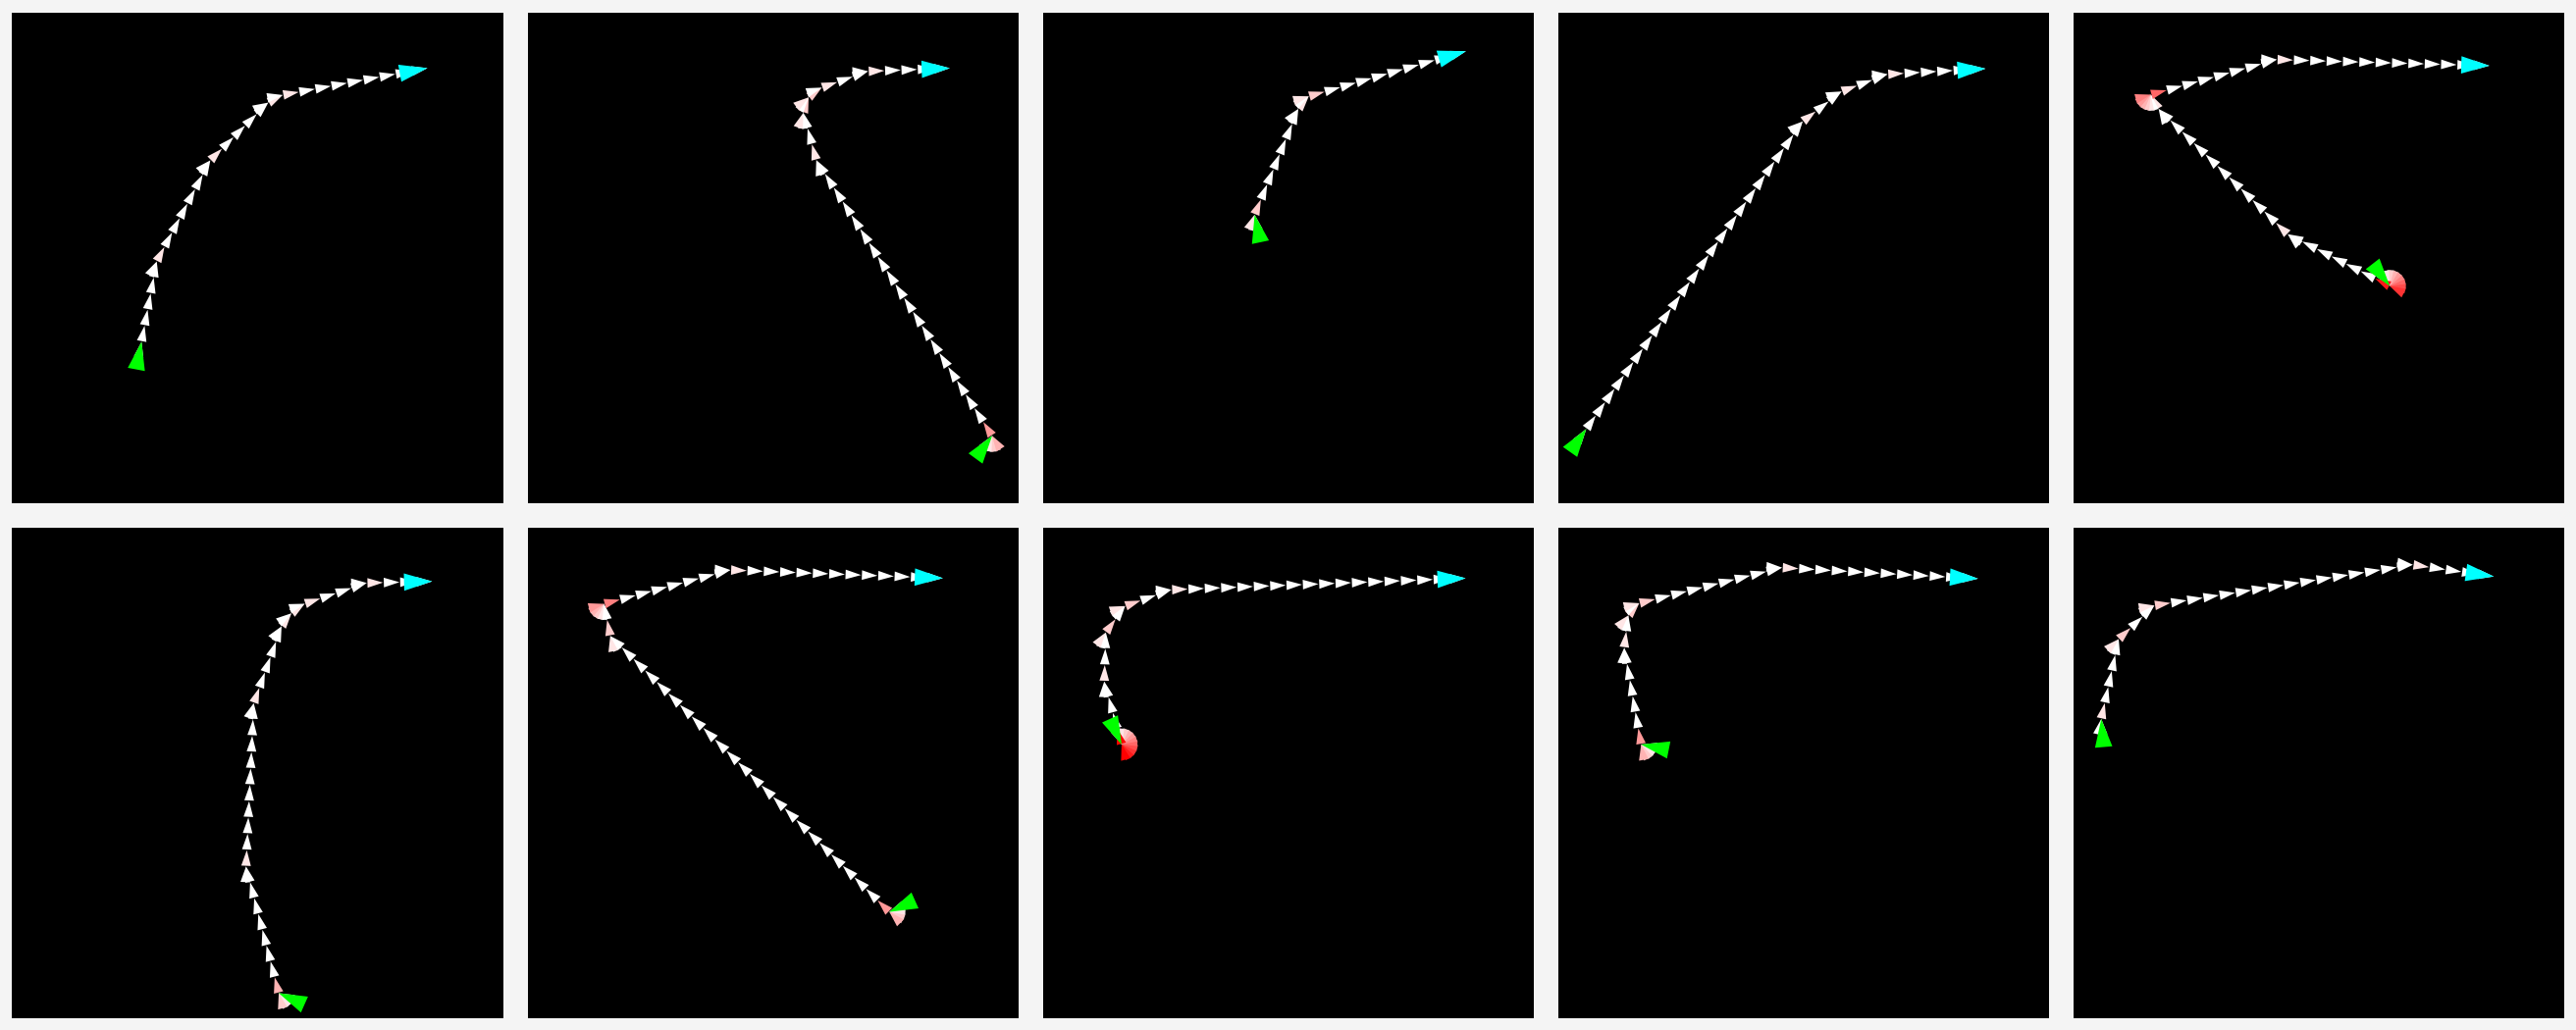

In [269]:
fig, ax = pplt.subplots(nrows=2, ncols=5)
for i in range(10):
    p = res['data']['pos'][i]
    a = res['data']['angle'][i]
    draw_trajectory(p, a, ax=ax[i])
ax.format(xlim=[0, 300], ylim=[0, 300])

In [263]:
pickle.dump(res, open('data/test', 'wb'))

In [238]:
pickle.dump(all_shortcut_results, open('data/shortcut/reset_performances', 'wb'))

In [135]:
np.mean(res['shortcut_theoretical_steps']) / np.mean(res['shortcut_actual_steps'])
np.mean(res['path_theoretical_steps']) / np.mean(res['path_actual_steps'])


0.920878149403271

In [138]:
pickle.dump(res, open('data/test', 'wb'))

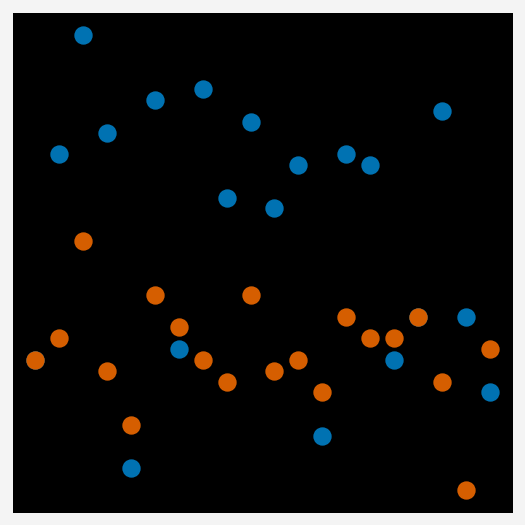

In [122]:
fig, ax = pplt.subplots()
ax.scatter(res['shortcut_actual_steps'])
ax.scatter(np.array(res['shortcut_theoretical_steps']).squeeze())

In [114]:
np.argwhere(~res['shortcuts_used'])

array([[11]], dtype=int64)

In [116]:
p, a = res['shortcut_starts'][11]

C:\Users\14and\anaconda3\lib\site-packages\matplotlib\patches.py:1117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy = np.asarray(xy)


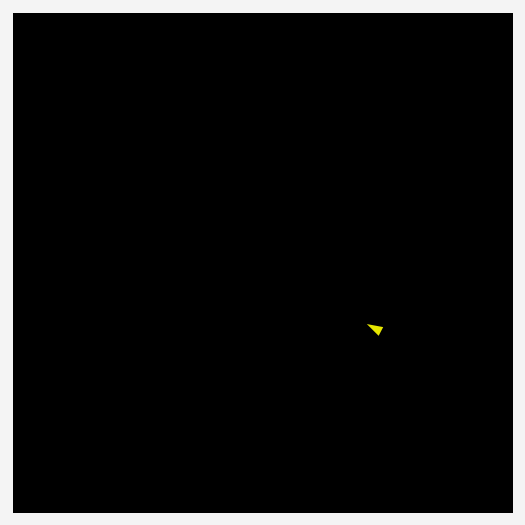

In [117]:
fig, ax = pplt.subplots()

draw_character(p, a, ax=ax)

ax.format(xlim=[0, 300], ylim=[0, 300])

Shortcut use rate: 1.0


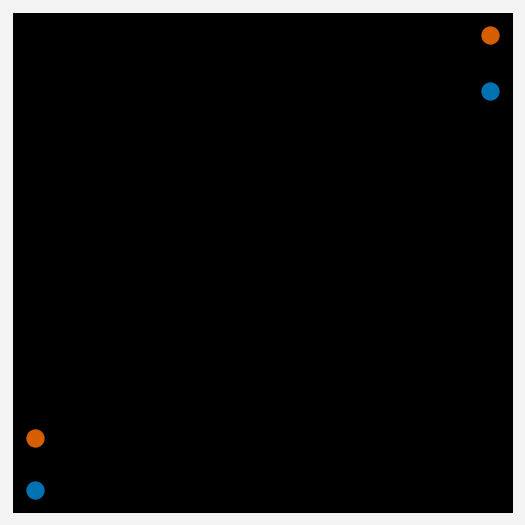

In [96]:
fig, ax = pplt.subplots()
ax.scatter([0, 1], [np.mean(shortcut_actual_steps), np.mean(path_actual_steps)], label='True episode lengths')
ax.scatter([0, 1], [np.mean(shortcut_optimal_steps), np.mean(path_optimal_steps)], label='Theoretical episode lengths')

print(f'Shortcut use rate: {np.sum(shortcuts_used)/n_eps}')

In [92]:
pos = res1['data']['pos'][0]
(np.diff(pos, axis=0)**2).sum(axis=1)

array([  0.,   0.,   0.,   0.,   0.,   0.,   0., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100.,   0., 100., 100., 100., 100., 100.,   0., 100.,   0.,
         0., 100., 100., 100.,   0., 100., 100., 100., 100., 100.])

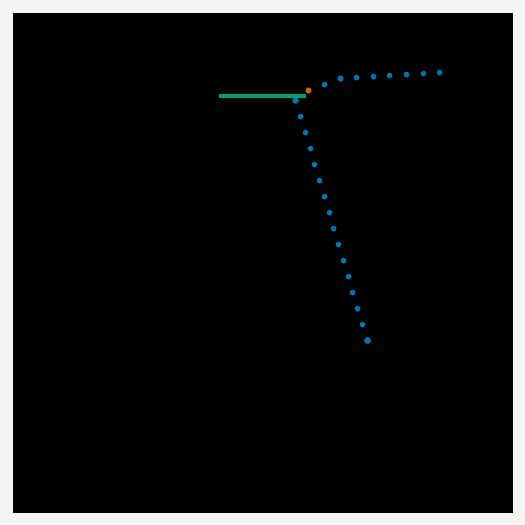

In [51]:
fig, ax = pplt.subplots()
ax.scatter(p.T[0], p.T[1], s=2)
# p2 = p[1:][(y1 & y2)]
p2 = p[1:][(y1 & y2) & (x1 | x2)]
# p2 = p[1:][(x1 | x2)]
ax.scatter(p2.T[0], p2.T[1], s=2)
ax.plot([125, 175], [250, 250])
ax.format(xlim=[0, 300], ylim=[0, 300])

shortcut: 62.0, path: 99.0


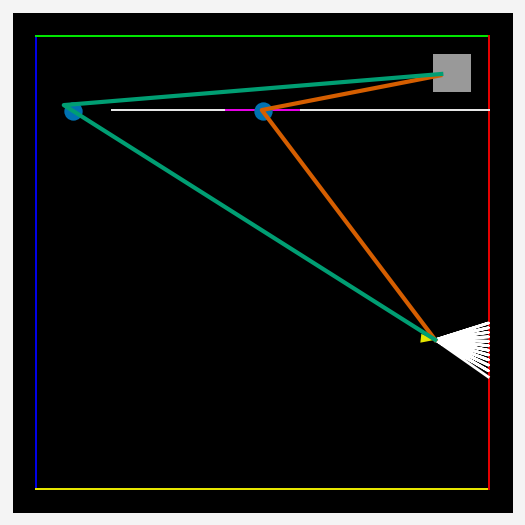

In [75]:
env.reset()
fig, ax = pplt.subplots()
env.render('human', ax=ax)
ax.scatter([150, 25], [250, 250])

char = env.character
angle = char.angle
pos = char.pos

shortcut_steps, shortcut_pos, shortcut_indiv = compute_path_steps(pos, angle, shortcut_target, True, True, True)
path_steps, path_pos, path_indiv = compute_path_steps(pos, angle, path_target, True, True, True)

p = np.vstack([pos, shortcut_pos])
ax.plot(p.T[0], p.T[1])
p = np.vstack([pos, path_pos])
ax.plot(p.T[0], p.T[1])

print(f'shortcut: {shortcut_steps}, path: {path_steps}')


In [76]:
shortcut_indiv

[8.0, 0.0, 7.0, 0.0, 19.0, 10.0, 12.0, 6.0]